# Distributed Angle & Distance Tracking with Extended Kalman Filter

This notebook demonstrates target tracking using a network of sensor nodes. Each node measures either:
- **Distance** to the target (even-numbered nodes)
- **Angle** to the target (odd-numbered nodes)

We implement a **Centralized Extended Kalman Filter (CEKF)** as a performance upper bound, assuming all measurements are available at a central fusion center.


### Imports


In [185]:
import importlib
import utils.ItayKfir.SystemData
importlib.reload(utils.ItayKfir.SystemData)
from utils.ItayKfir.SystemData import Node, HSystem, FSystemLinear, plot_trajectory_and_nodes

import os
import sys
# Add parent directory to path to allow importing utils
sys.path.append(os.path.abspath('..'))

import torch
import random
import numpy as np
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

torch.set_default_dtype(torch.float)

# Imports from utils as requested
from utils.ClassicDistributedKalman import diffusion_extended_kalman_filter_parallel_edge
from utils.ItayKfir.SystemData import FSystemLinear, HSystem, Node, plot_trajectory_and_nodes, generate_data_points, generate_measurements
from utils.DistributedKalmanNet import GraphKalmanProcess, StateKnowledge
from utils.BaselineModels import GnnRnnLightning
from utils.experiment_utils import seed_everything
from utils.experiment_utils import run_experiment_classical_diffusion_kalman
from utils.experiment_utils import mean_distance_function
from utils.experiment_utils import consensus_distance_function
from utils.experiment_utils import create_experiment_config
from utils.experiment_utils import NanInfChecker
from utils.experiment_utils import SkipNaNBatch

## 1. Simulation Setup

### Configuration Parameters
- `node_num`: Number of sensor nodes in the network
- `time_steps`: Duration of the simulation
- `state_noise_level_q`: Process noise standard deviation
- `measurement_noise_level_r`: Measurement noise standard deviation

### State Space Model
The target follows a constant velocity model with state vector $\mathbf{x} = [x, v_x, y, v_y]^T$:

$$\mathbf{x}_{k+1} = \mathbf{F} \mathbf{x}_k + \mathbf{w}_k$$

where $\mathbf{F}$ is the state transition matrix and $\mathbf{w}_k \sim \mathcal{N}(0, Q)$ is process noise.


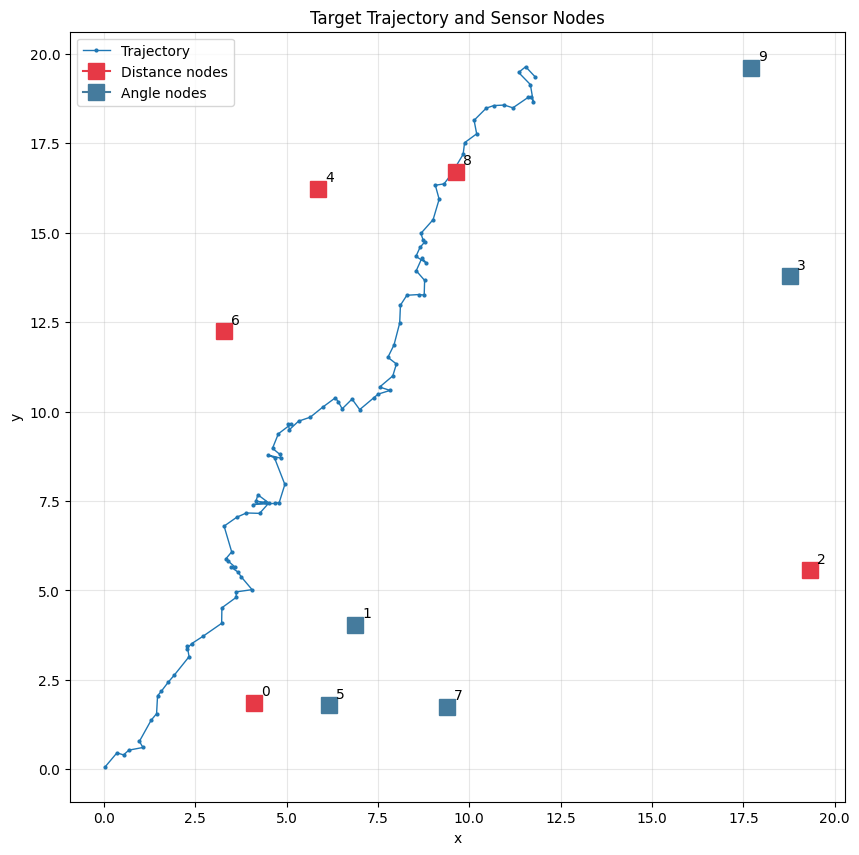

In [186]:
from sympy.printing.pretty.pretty import xobj
from torch.utils import data

# configuration
node_num = 10
time_steps = 50
state_noise_level_q = 0.2
measurement_noise_level_r = 0.1
r_array = measurement_noise_level_r * np.ones(node_num)

# State space model
f = FSystemLinear(time_delta = 0.1)
nodes = np.array([[Node(node_num = i, node_position = np.random.rand(2,1) * 20) for i in range(node_num)]])
h_vector = np.array([nodes[0][i].observation_model for i in range(node_num)])

x_init = np.array([[0, 1, 0, 2]])  # initial state vector [x, vx, y, vy]
data_points = generate_data_points(F_system=f, x0=x_init.T, time_steps=100, state_noise_level=state_noise_level_q)
observation_noise_vector_R = np.random.randn(node_num) * measurement_noise_level_r
measurements = generate_measurements(h_vector, node_num, data_points, measurement_noise_level_r)

# Plot trajectory and nodes
plot_trajectory_and_nodes(nodes, data_points)

## 2. Centralized Extended Kalman Filter

The EKF performs state estimation using nonlinear observations from all nodes.

### Observation Models
- **Distance nodes** (even): $h_i(\mathbf{x}) = \sqrt{(x - x_i)^2 + (y - y_i)^2}$
- **Angle nodes** (odd): $h_i(\mathbf{x}) = \arctan2(y - y_i, x - x_i)$

### EKF Equations
**Prediction:**
$$\hat{\mathbf{x}}_{k|k-1} = \mathbf{F} \hat{\mathbf{x}}_{k-1|k-1}$$
$$\mathbf{P}_{k|k-1} = \mathbf{F} \mathbf{P}_{k-1|k-1} \mathbf{F}^T + \mathbf{Q}$$

**Update:**
$$\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}_k^T (\mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^T + \mathbf{R})^{-1}$$
$$\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k (\mathbf{y}_k - h(\hat{\mathbf{x}}_{k|k-1}))$$
$$\mathbf{P}_{k|k} = (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k) \mathbf{P}_{k|k-1}$$

where $\mathbf{H}_k = \frac{\partial h}{\partial \mathbf{x}}\big|_{\hat{\mathbf{x}}_{k|k-1}}$ is the Jacobian of the observation function.


In [187]:
def centralized_extended_kalman_filter(measurements: np.ndarray, f_system: FSystemLinear, 
                                       nodes: np.ndarray, r_array: np.ndarray, 
                                       q: float, p0: np.ndarray, x0: np.ndarray) -> np.ndarray:
    """
    Centralized Extended Kalman Filter (CEKF).
    Performance upper bound assuming all measurements available at a central node.
    
    Args:
        measurements: shape (time_steps, node_num) - observations from all nodes
        f_system: State transition system (FSystemLinear)
        nodes: Array of Node objects, shape (1, node_num) or (node_num,)
        r_array: Measurement noise std for each node, shape (node_num,)
        q: Process noise std (scalar)
        p0: Initial covariance matrix, shape (state_dim, state_dim)
        x0: Initial state estimate, shape (state_dim, 1)
    
    Returns:
        x_hat: State estimates, shape (time_steps, state_dim, 1)
    
    Standard EKF equations:
    1. Prediction: x̂_{k|k-1} = f(x̂_{k-1|k-1}), P_{k|k-1} = F*P*F^T + Q
    2. Update: K = P*H^T*(H*P*H^T + R)^(-1)
               x̂_{k|k} = x̂_{k|k-1} + K*(y - h(x̂_{k|k-1}))
    """
    # Handle different node array shapes
    node_list = nodes[0] if nodes.ndim == 2 else nodes
    node_num = len(node_list)
    
    time_steps = measurements.shape[0]
    state_dim = x0.shape[0]
    
    x_hat = np.zeros((time_steps, state_dim, 1))
    R = np.diag(r_array ** 2)  # Measurement noise covariance
    Q = q ** 2 * np.eye(state_dim)  # Process noise covariance
    
    P = p0.copy()
    x_pred = x0.copy()
    F = f_system.jacobian()  # For linear system, F is constant
    
    for k in range(time_steps):
        # --- Update step ---
        # Compute H (Jacobian) and y_pred for all nodes
        H = np.zeros((node_num, state_dim))
        y_pred = np.zeros(node_num)
        
        x_tensor = torch.tensor(x_pred, dtype=torch.float).squeeze()
        for j, node in enumerate(node_list):
            # Predicted observation
            obs = node.observation_model(x_pred)
            y_pred[j] = obs.item() if isinstance(obs, torch.Tensor) else float(obs)
            # Jacobian
            jac = node.h.jacobian(x_tensor[None, :])
            H[j, :] = jac.detach().numpy() if isinstance(jac, torch.Tensor) else jac
        
        # Innovation covariance: S = H * P * H^T + R
        S = H @ P @ H.T + R
        
        # Kalman gain: K = P * H^T * S^(-1)
        K = P @ H.T @ np.linalg.inv(S)
        
        # Innovation: y - h(x_pred)
        innovation = measurements[k, :] - y_pred
        
        # State update: x̂_{k|k} = x̂_{k|k-1} + K * innovation
        x_current = x_pred + (K @ innovation[:, None])
        
        # Covariance update: P_{k|k} = (I - K*H) * P
        P = (np.eye(state_dim) - K @ H) @ P
        
        x_hat[k, ...] = x_current
        
        # --- Prediction step for next iteration ---
        # x̂_{k+1|k} = F * x̂_{k|k}
        x_pred = f_system(x_current)
        
        # P_{k+1|k} = F * P * F^T + Q
        P = F @ P @ F.T + Q
    
    return x_hat



## 3. Run EKF and Visualize Results

Execute the centralized EKF and compare the estimated trajectory against the ground truth.

The plots show:
1. **Trajectory comparison**: True path (blue) vs EKF estimate (red dashed)
2. **Position error over time**: Euclidean distance between true and estimated positions


/var/folders/qy/t693zbgs4gzfck47wyy46qwr0000gp/T/ipykernel_22830/2905154092.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[j] = obs.item() if isinstance(obs, torch.Tensor) else float(obs)


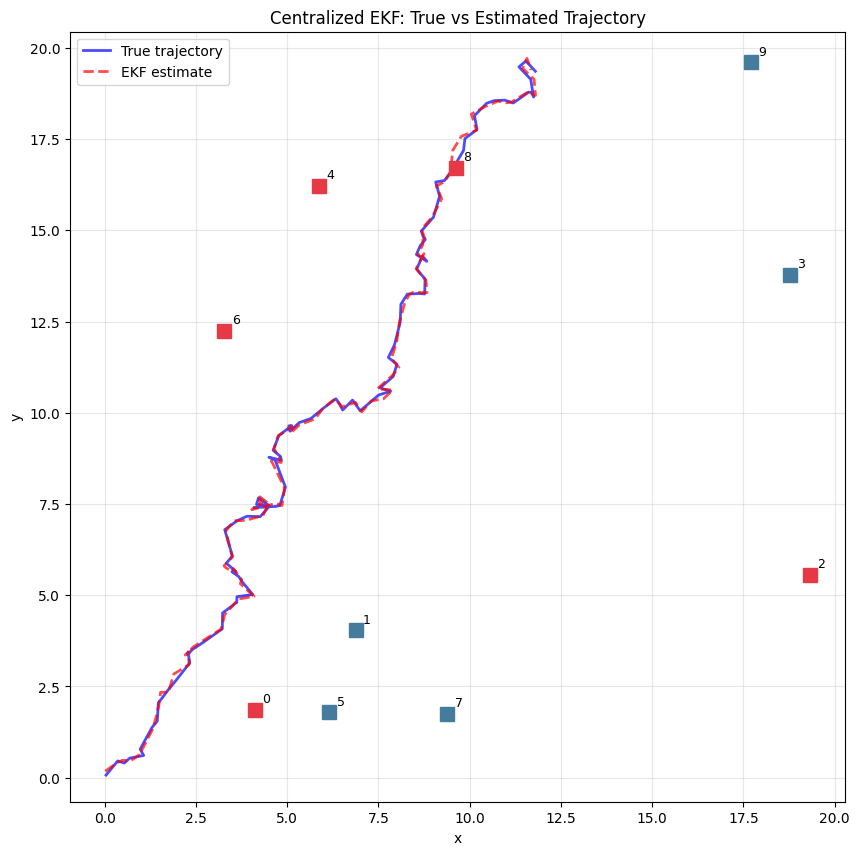

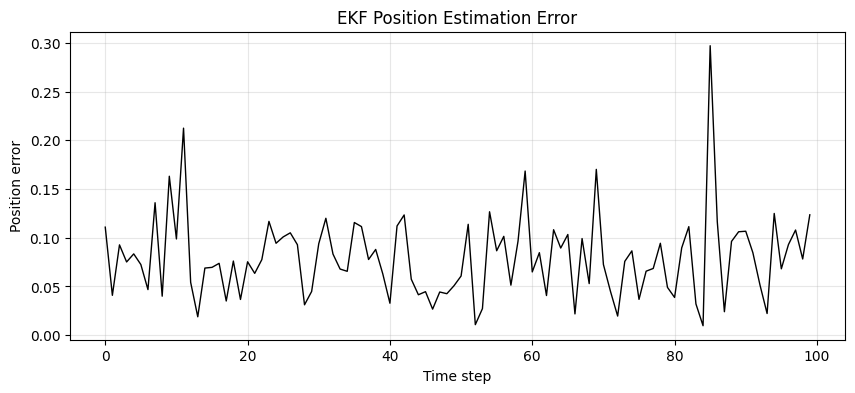

Mean position error: 0.0795
Final position error: 0.1235


In [188]:
# Example usage of the Centralized EKF

# Initial state estimate and covariance
state_dim = 4
x0_estimate = np.array([[0], [0], [0], [0]], dtype=float)  # Initial guess [x, vx, y, vy]
p0 = np.eye(state_dim) * 10  # Initial covariance (high uncertainty)

# Run the EKF
x_hat = centralized_extended_kalman_filter(
    measurements=measurements,
    f_system=f,
    nodes=nodes,
    r_array=r_array,
    q=state_noise_level_q,
    p0=p0,
    x0=x0_estimate
)

# Plot results: true trajectory vs estimated
plt.figure(figsize=(10, 10))

# True trajectory
x_true = data_points[:, 0, 0].numpy()
y_true = data_points[:, 2, 0].numpy()
plt.plot(x_true, y_true, 'b-', linewidth=2, label='True trajectory', alpha=0.7)

# Estimated trajectory
x_est = x_hat[:, 0, 0]
y_est = x_hat[:, 2, 0]
plt.plot(x_est, y_est, 'r--', linewidth=2, label='EKF estimate', alpha=0.7)

# Plot nodes
for i in range(node_num):
    node_pos = nodes[0][i].node_position
    node_type = nodes[0][i].node_classification
    x_pos, y_pos = node_pos[0, 0], node_pos[1, 0]
    color = '#e63946' if node_type == 0 else '#457b9d'
    plt.plot(x_pos, y_pos, marker='s', markersize=10, color=color)
    plt.text(x_pos + 0.2, y_pos + 0.2, f'{i}', fontsize=9)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Centralized EKF: True vs Estimated Trajectory')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Plot estimation error over time
error = np.sqrt((x_true - x_est)**2 + (y_true - y_est)**2)
plt.figure(figsize=(10, 4))
plt.plot(error, 'k-', linewidth=1)
plt.xlabel('Time step')
plt.ylabel('Position error')
plt.title('EKF Position Estimation Error')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean position error: {np.mean(error):.4f}")
print(f"Final position error: {error[-1]:.4f}")
